In [9]:
import numpy as np
import os, sys
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
import itertools
import scipy.stats
import tensorflow as tf
from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels


In [10]:
folder = 'dataset'
#mudei essas linhas de baixo pois estava em 120
image_width = 64
image_height = 64
channels = 3

train_files = []
i=0
for coin in [5, 10, 25, 50, 100]:
    onlyfiles = [f for f in os.listdir(folder + '/' + str(coin)) if os.path.isfile(os.path.join(folder + '/' + str(coin), f))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)
y_dataset = []

i = 0
for coin in [5, 10, 25, 50, 100]:
    onlyfiles = [f for f in os.listdir(folder + '/' + str(coin)) if os.path.isfile(os.path.join(folder + '/' + str(coin), f))]
    for _file in onlyfiles:
        #img = load_img(folder + '/' +  str(coin) + '/' + _file)  # this is a PIL image
        #img.thumbnail((image_width, image_height))
        # Convert to Numpy Array
        #x = img_to_array(img)
        # open with opencv
        x = np.array(cv2.imread(folder + '/' +  str(coin) + '/' + _file))
        #x = x.reshape((3, 120, 160))
        # Normalize
        #x = (x - 128.0) / 128.0

        dataset[i] = x
        mapping = {5: 0, 10: 1, 25: 2, 50: 3, 100: 4}
        y_dataset.append(mapping[coin])
        i += 1
        if i % 250 == 0:
            print("%d images to array" % i)
print("All images to array!")

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
All images to array!


In [11]:
# normalize
dataset = dataset.astype('float32')
dataset /= 255

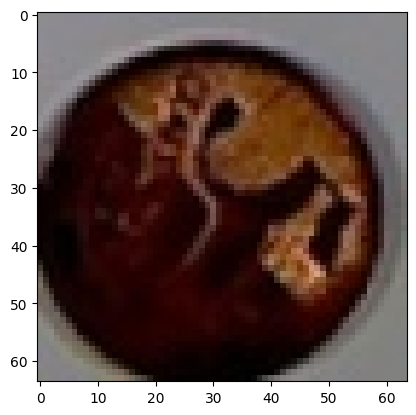

In [12]:
pixels = np.array(dataset[0], dtype='float32')
#pixels = pixels.reshape((64, 64, 3))
plt.imshow(cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB))
plt.show()
#print(scaled_labels[0])

In [13]:
# categorical values
n_classes = len(set(y_dataset))
print(n_classes)

y_dataset_ = to_categorical(y_dataset, n_classes)

5


In [14]:
# splitting into training and test
#Splitting
X_train, X_test, y_train, y_test = train_test_split(dataset, y_dataset_, test_size=0.2)
print("Train set size: {0}, Test set size: {1}".format(len(X_train), len(X_test)))

Train set size: 2630, Test set size: 658


In [15]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=90, shear_range=0.2, horizontal_flip=True, fill_mode='nearest')

datagen.fit(X_train)

In [16]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=(64, 64, 3)))
model.add(tf.keras.layers.Conv2D(filters= 128, kernel_size=(5, 5), activation='relu', strides=(1,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters= 64, kernel_size=(3, 3), activation='relu', strides=(1,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters= 32, kernel_size=(2, 2), activation='relu', strides=(1,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 64, activation='relu'))
model.add(Dropout(0.1))
model.add(tf.keras.layers.Dense(units = 5, activation='softmax', name = 'saida'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 64, 64, 3)         12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 128)       9728      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'max', patience = 10)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks = [early_stopping])


Epoch 1/100


66/66 [==============================] - 110s 2s/step - loss: 1.1797 - accuracy: 0.4995 - val_loss: 1.3415 - val_accuracy: 0.5856
Epoch 2/100
39/66 [================>.............] - ETA: 44s - loss: 0.8110 - accuracy: 0.6611

KeyboardInterrupt: 

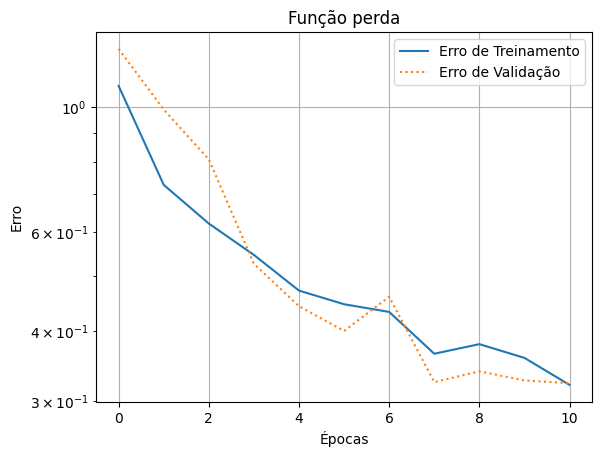

In [ ]:
# Visualizando o ERRO de treinamento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], ':')
plt.title('Função perda')
plt.yscale('log')
plt.ylabel('Erro')
plt.xlabel('Épocas')
plt.legend(['Erro de Treinamento', 'Erro de Validação'])
plt.grid(True)
plt.show()

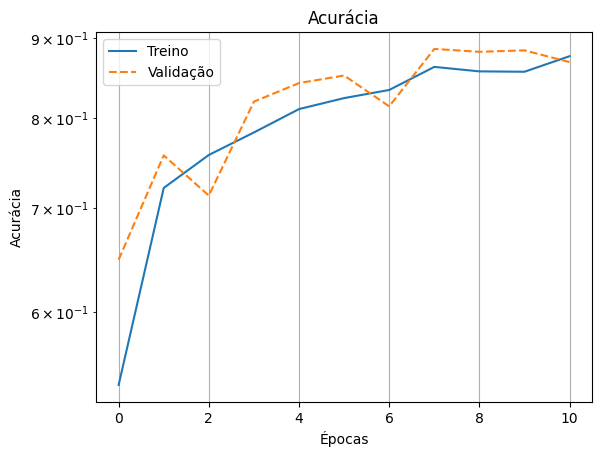

In [ ]:
# Plotando o treinamento e a validação da accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '--')
plt.yscale("log")
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'])
plt.grid(True)
plt.show()

In [ ]:
preds = model.predict(X_test)

21/21 [==============================] - 9s 395ms/step


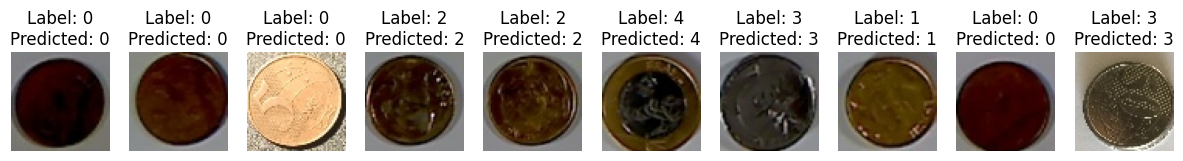

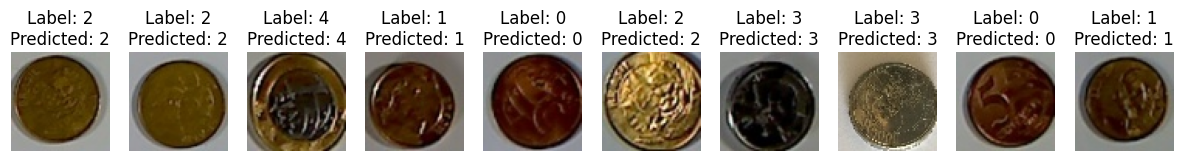

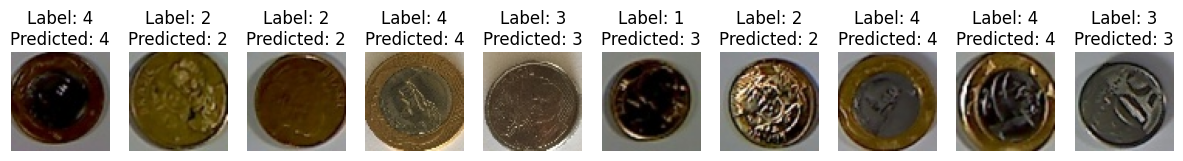

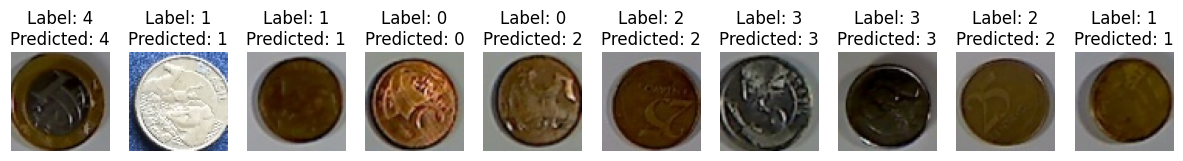

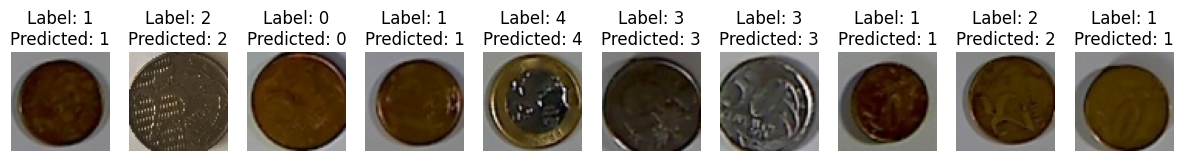

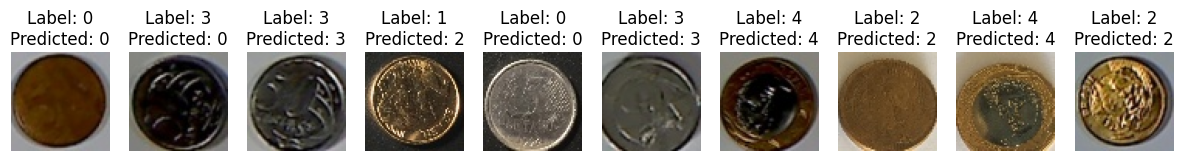

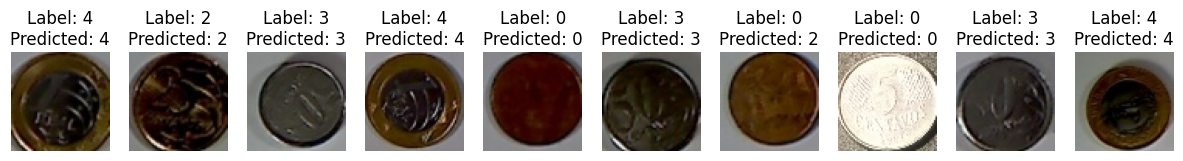

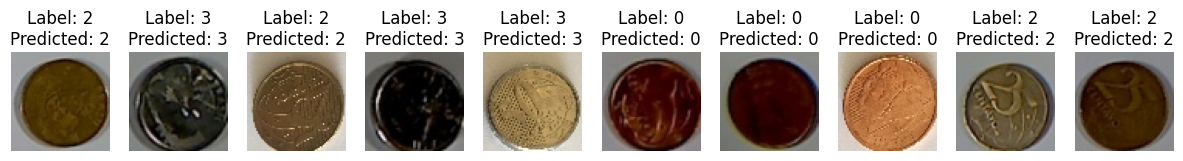

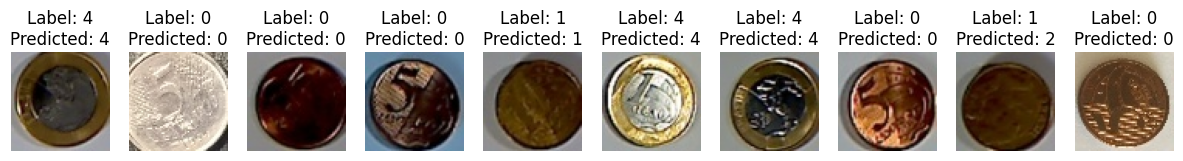

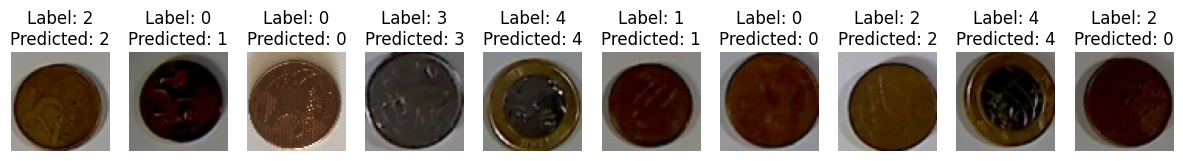

In [ ]:
n = 10
for t in range(10):
    plt.figure(figsize=(15,15))
    for i in range(n*t, n*(t+1)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title('Label: {}\nPredicted: {}'.format(np.argmax(y_test[i]), np.argmax(preds[i])))
        plt.axis('off')
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

Confusion matrix, without normalization
[[134   2   5   0   0]
 [  7 112  17   2   0]
 [ 12  12  98   0   1]
 [ 10   0   5 111   0]
 [  0   0   0   0 130]]


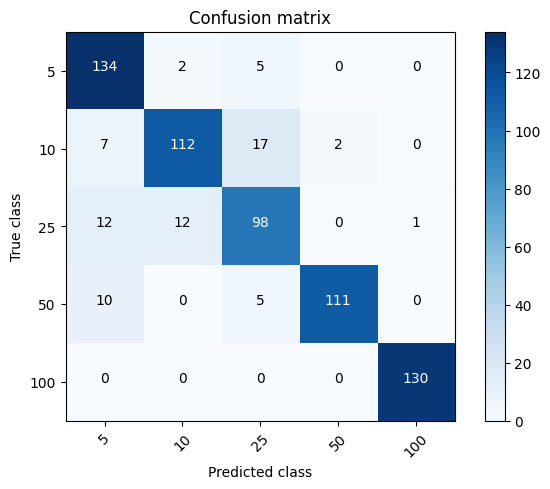

In [ ]:
# Plot non-normalized confusion matrix
#y_test_ = np.apply_along_axis(np.argmax, 1, y_test)
#preds_ = np.apply_along_axis(np.argmax, 1, preds)
y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

cm = confusion_matrix(y_test_, preds_)
plt.figure()
plot_confusion_matrix(cm, classes=['5', '10', '25', '50', '100'], title='Confusion matrix')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: {:.2f}%".format(accuracy * 100))

21/21 [==============================] - 8s 389ms/step - loss: 0.2884 - accuracy: 0.8891
Loss:  0.28840765357017517
Accuracy: 88.91%


In [ ]:
# Convertendo as previsões e os rótulos de volta para as classes originais
y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]


In [ ]:
# Calcular acurácia
accuracy = accuracy_score(y_test_, preds_)
print("Acurácia:", accuracy)

Acurácia: 0.8890577507598785


In [ ]:
# Calcular precisão
precision = precision_score(y_test_, preds_, average='macro')
print("Precisão:", precision)

Precisão: 0.8939284151257867


In [ ]:
# Calcular recall
recall = recall_score(y_test_, preds_, average='macro')
print("Recall:", recall)

Recall: 0.8879298322519368


In [ ]:
# Calcular F1 score
f1 = f1_score(y_test_, preds_, average='macro')
print("F1-score:", f1)

F1-score: 0.8890850503521879


In [ ]:
# Testando o modelo
teste_image_path = 'moeda.jpg'  # Substitua pelo caminho da sua imagem de teste
teste_image = tf.keras.preprocessing.image.load_img(teste_image_path, target_size=(64, 64))
teste_image_array = tf.keras.preprocessing.image.img_to_array(teste_image)
teste_image_array = np.expand_dims(teste_image_array, axis=0)  # Adiciona uma dimensão para representar o lote (batch)

# Predição
saida_predita = model.predict(teste_image_array)

print('Saída Preditada:', saida_predita)


1/1 [==============================] - 0s 85ms/step
Saída Preditada: [[0. 0. 1. 0. 0.]]


In [ ]:
# Mapeamento de números de classe para nomes de classe
class_name = {
    0: "Moeda de 5 centavos",
    1: "Moeda de 10 centavos",
    2: "Moeda de 25 centavos",
    3: "Moeda de 50 centavos",
    4: "Moeda de 1 real"
}

# Obtém o número da classe prevista
classe_prevista = np.argmax(saida_predita)

# Obtém o nome da classe prevista usando o mapeamento
nome_classe_prevista = class_name[classe_prevista]

print('Classe Prevista:', nome_classe_prevista)

Classe Prevista: Moeda de 25 centavos


In [ ]:
# saving model
model.save('model.h5')

c:\Users\BRUNO WELL\Desktop\contador de moedas real\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#dados = pd.DataFrame(history.history)
#dados.head()

In [ ]:
#dados.to_csv('loss.csv')